We load the enriched dataset which includes product information, pricing, health scores and order values.

The dataset is large (13M+ rows), so later we will sample orders to make mining computationally efficient.

In [10]:
import pandas as pd
import numpy as np

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

df = pd.read_parquet("data/processed/instacart_enriched_health_parquet")
print(df.shape)
print(df.columns[:20])


(13367966, 22)
Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'nutriscore_grade', 'main_category',
       'health_points', 'unit_price', 'order_value'],
      dtype='str')


Only using the Order_id & product_name columns because of size and because we want item combinations

In [11]:
df_fp = df[['order_id','product_name']]

The dataset is quite large and because of this we would be sampling 150k orders.
We sample because FP-growth is heavy and the patterns remain valid even on subset.

In [12]:
sample_orders = np.random.choice(df_fp['order_id'].unique(), size=150000, replace=False)
df_fp = df_fp[df_fp['order_id'].isin(sample_orders)]
df_fp.head()

,order_id,product_name
0,4,Plain Pre-Sliced Bagels
1,4,Honey/Lemon Cough Drops
2,4,Chewy 25% Low Sugar Chocolate Chip Granola
3,4,Oats & Chocolate Chewy Bars
4,4,Kellogg's Nutri-Grain Apple Cinnamon Cereal


Creating Transactions - Each order is converted into a list of purchased products.

In [13]:
transactions = (
    df_fp.groupby('order_id')['product_name']
    .apply(list)
    .tolist()
)

In [14]:
transactions[:5]

[['Plain Pre-Sliced Bagels',
  'Honey/Lemon Cough Drops',
  'Chewy 25% Low Sugar Chocolate Chip Granola',
  'Oats & Chocolate Chewy Bars',
  "Kellogg's Nutri-Grain Apple Cinnamon Cereal",
  'Nutri-Grain Soft Baked Strawberry Cereal Breakfast Bars',
  "Kellogg's Nutri-Grain Blueberry Cereal",
  'Tiny Twists Pretzels',
  'Traditional Snack Mix',
  'Goldfish Cheddar Baked Snack Crackers',
  'Original Orange Juice',
  'Sugarfree Energy Drink',
  'Energy Drink'],
 ['Bag of Organic Bananas',
  'Just Crisp, Parmesan',
  'Fresh Fruit Salad',
  'Organic Raspberries',
  '2% Reduced Fat Milk',
  'Sensitive Toilet Paper',
  'Natural Artesian Water, Mini & Mobile',
  'Matzos, Thin, Tea',
  'Boneless Skinless Chicken Breast Fillets',
  'Mini Original Babybel Cheese',
  'Macaroni And Cheese',
  'Clementines',
  "Biscuits Orange Pim's",
  'Dairy Milk Fruit & Nut Chocolate Bar',
  'Artichokes',
  'Apricot Preserves',
  'One Ply Choose A Size Big Roll Paper Towel Rolls',
  'Wafer, Chocolate',
  'French 

Encoding our Baskets - The transformation will allow the algorithm to detect frequent item combinations.

In [15]:
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
basket = pd.DataFrame(te_array, columns=te.columns_)

In [16]:
basket.head()
basket.shape

(150000, 34377)

FP Growth - It identifies frequently purchased itemsets.
We set min_support = 1% to focus on meaningful and recurring purchase patterns.

Find products that are bought together frequently.

In [17]:
freq_items = fpgrowth(basket, min_support=0.01, use_colnames=True)
freq_items.sort_values("support", ascending=False).head(15)

,support,itemsets
32,0.136987,frozenset({Banana})
12,0.114787,frozenset({Organic Baby Spinach})
1,0.105213,frozenset({Bag of Organic Bananas})
50,0.083160,frozenset({Organic Avocado})
37,0.075433,frozenset({Organic Strawberries})
6,0.066293,frozenset({Organic Whole Milk})
2,0.057280,frozenset({Organic Raspberries})
3,0.053220,frozenset({Organic Hass Avocado})
16,0.046033,frozenset({Organic Blueberries})
46,0.044800,frozenset({Large Lemon})


In [18]:
freq_items.head()
freq_items.shape

(144, 2)

Association Rules - To show relationships between products

In [19]:
rules = association_rules(freq_items, metric="lift", min_threshold=1.2)
rules = rules.sort_values(['lift','confidence'], ascending=False)
rules.head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
5,frozenset({Organic Raspberries}),frozenset({Organic Strawberries}),0.057280,0.075433,0.012500,0.218226,2.892968,1.0,0.008179,1.182652,0.694092,0.103982,0.154443,0.191968
4,frozenset({Organic Strawberries}),frozenset({Organic Raspberries}),0.075433,0.057280,0.012500,0.165709,2.892968,1.0,0.008179,1.129966,0.707720,0.103982,0.115017,0.191968
29,frozenset({Organic Avocado}),frozenset({Large Lemon}),0.083160,0.044800,0.010620,0.127706,2.850572,1.0,0.006894,1.095043,0.708077,0.090506,0.086794,0.182380
28,frozenset({Large Lemon}),frozenset({Organic Avocado}),0.044800,0.083160,0.010620,0.237054,2.850572,1.0,0.006894,1.201710,0.679641,0.090506,0.167852,0.182380
6,frozenset({Bag of Organic Bananas}),frozenset({Organic Hass Avocado}),0.105213,0.053220,0.014000,0.133063,2.500244,1.0,0.008401,1.092098,0.670595,0.096931,0.084331,0.198061
7,frozenset({Organic Hass Avocado}),frozenset({Bag of Organic Bananas}),0.053220,0.105213,0.014000,0.263059,2.500244,1.0,0.008401,1.214190,0.633768,0.096931,0.176406,0.198061
3,frozenset({Organic Raspberries}),frozenset({Bag of Organic Bananas}),0.057280,0.105213,0.014700,0.256634,2.439178,1.0,0.008673,1.203696,0.625876,0.099463,0.169226,0.198175
2,frozenset({Bag of Organic Bananas}),frozenset({Organic Raspberries}),0.105213,0.057280,0.014700,0.139716,2.439178,1.0,0.008673,1.095824,0.659404,0.099463,0.087445,0.198175
15,frozenset({Honeycrisp Apple}),frozenset({Banana}),0.035707,0.136987,0.011607,0.325056,2.372903,1.0,0.006715,1.278644,0.599999,0.072052,0.217922,0.204892
14,frozenset({Banana}),frozenset({Honeycrisp Apple}),0.136987,0.035707,0.011607,0.084728,2.372903,1.0,0.006715,1.053560,0.670413,0.072052,0.050837,0.204892


Produce items dominate because they are purchased most frequently across many baskets.This is expected in retail data since fruits and fresh items are commonly bought across different types of orders.

Support = This shows how often an item appears in all orders.
Using the first result.
Confidence : If someone buys raspberries there is a 21% chance they also buy strawberries
Lift: It means they are almost 3 times more likely to be bought together.

These patterns can help retailers design product bundles, improve store layout and create targeted promotions.

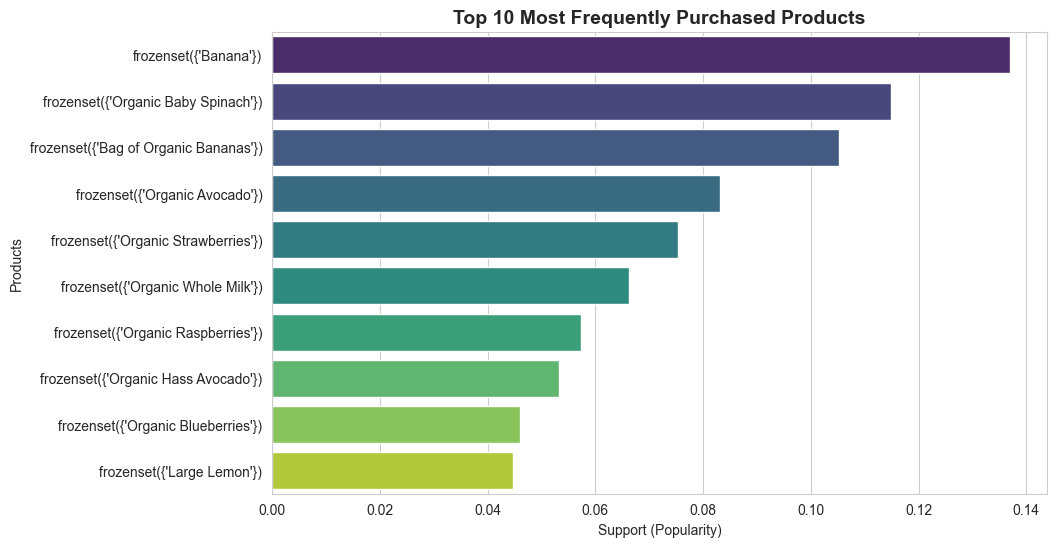

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

top_items = freq_items.sort_values('support', ascending=False).head(10)

plt.figure(figsize=(10,6))

sns.barplot(
    x='support',
    y=top_items['itemsets'].astype(str),
    hue=top_items['itemsets'].astype(str),
    data=top_items,
    palette="viridis",
    legend=False
)

plt.title("Top 10 Most Frequently Purchased Products", fontsize=14, weight='bold')
plt.xlabel("Support (Popularity)")
plt.ylabel("Products")
plt.show()


This chart shows the products that appear in the highest percentage of baskets. It is the most commonly bought items.

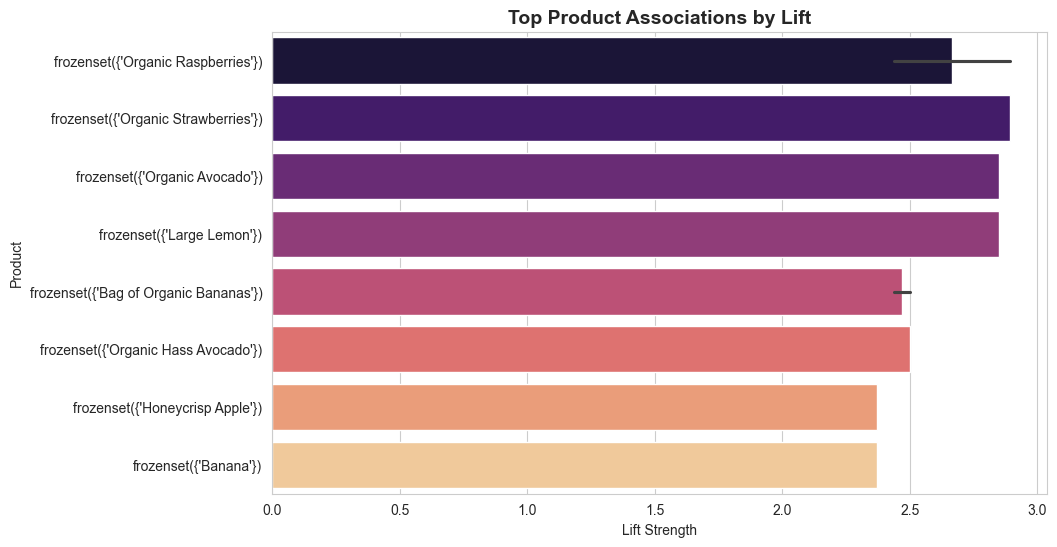

In [25]:
top_rules = rules.sort_values('lift', ascending=False).head(10)

plt.figure(figsize=(10,6))

sns.barplot(
    x='lift',
    y=top_rules['antecedents'].astype(str),
    hue=top_rules['antecedents'].astype(str),
    data=top_rules,
    palette="magma",
    legend=False
)

plt.title("Top Product Associations by Lift", fontsize=14, weight='bold')
plt.xlabel("Lift Strength")
plt.ylabel("Product")
plt.show()


This chart highlights the strongest product pairings. A lift above 1 means they are positively associated. It means the higher the lift, the stronger the relationship.